#Hospital Compare - Readmission rates: 
#https://data.medicare.gov/Hospital-Compare/Hospital-Readmissions-Reduction-Program/9n3s-kdb3

#Hospital Info (including addresses):
#https://data.medicare.gov/Hospital-Compare/Hospital-General-Information/xubh-q36u

#2017 Wage Index:
#https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Wage-Index-Files-Items/FY2017-Wage-Index-Home-Page.html?DLPage=1&DLEntries=10&DLSort=1&DLSortDir=descending

#Census Data - median household income by county

### Set up

In [240]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

#import special programs
import us_state_abbrev

In [3]:
# if needed: pip install requests or conda install requests
import requests

requests.__path__

['/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/requests']

## import healthdata.gov datasets using API
HRRP API info: https://dev.socrata.com/foundry/data.medicare.gov/9n3s-kdb3
General Hospital API info: https://dev.socrata.com/foundry/data.medicare.gov/rbry-mqwu

ONLY RUN AS NEEDED AS THERE ARE STRICT THROTTLING LIMITS WITHOUT TOKEN! USE THE PICKLES

In [77]:
#!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.medicare.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.medicare.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # Results returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# hrrp = client.get("9n3s-kdb3", limit=20000) #Readmissions scores
# geninfo = client.get("rbry-mqwu", limit=6000) #General hospital information

# # Convert to pandas DataFrame
# hrrp_df = pd.DataFrame.from_records(hrrp)
# geninfo_df = pd.DataFrame.from_records(geninfo)

In [82]:
# #pickle the datasets for later use
# with open('hrrp.pickle', 'wb') as to_write:
#     pickle.dump(hrrp_df, to_write)

# with open('geninfo.pickle', 'wb') as to_write:
#     pickle.dump(geninfo_df, to_write)
    
# !ls

## Import hospital wage index data

In [31]:
# local_path = "../../project 2/FY2017-NPRM-Tables-2-and-3/CMS 1655-P FY 2017 Proposed Rule Table 2.txt"
# local_path = "Users/Jocelyn/Metis/local projects/project 2/FY2017-NPRM-Tables-2-and-3/CMS 1655-P FY 2017 Proposed Rule Table 2.txt"
local_path = "CMS 1655-P FY 2017 Proposed Rule Table 2_2.txt"
wageindex = pd.read_csv(local_path, delimiter = "\t",header=None,names=['CCN','Case_Mix_Indexes','FY_2017_Wage_Index','Avg_Hourly_Wage_FY2015',
                                                                        'Avg_Hourly_Wage_FY2016','Avg_Hourly_Wage_FY2017','3_Year_Avg_Hourly_Wage_15_16_17',
                                                                        'Geographic_CBSA','Reclassified_Redesignated_CBSA','Lugar_NECMA','MGCRB_Reclass',
                                                                        'Hosp_Reclass','Out_Migration_Adj','County_Name','County_Code'])
wageindex.info()

with open('wageindex.pickle', 'wb') as to_write:
    pickle.dump(wageindex, to_write)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Data columns (total 15 columns):
CCN                                3586 non-null object
Case_Mix_Indexes                   3417 non-null float64
FY_2017_Wage_Index                 3586 non-null float64
Avg_Hourly_Wage_FY2015             3408 non-null float64
Avg_Hourly_Wage_FY2016             3367 non-null float64
Avg_Hourly_Wage_FY2017             3354 non-null float64
3_Year_Avg_Hourly_Wage_15_16_17    3483 non-null float64
Geographic_CBSA                    3586 non-null int64
Reclassified_Redesignated_CBSA     992 non-null float64
Lugar_NECMA                        68 non-null object
MGCRB_Reclass                      867 non-null object
Hosp_Reclass                       57 non-null object
Out_Migration_Adj                  693 non-null float64
County_Name                        3586 non-null object
County_Code                        3586 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 

## Import county income data

In [217]:
local_path2 = "census_income_data.csv"
censusincome = pd.read_csv(local_path2,skiprows=[0])

censusincome.info()
censusincome.head(5)

with open('censusincome.pickle', 'wb') as to_write:
    pickle.dump(censusincome, to_write)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Columns: 130 entries, id to Nonfamily households!!Margin of Error!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
dtypes: float64(83), int64(22), object(25)
memory usage: 3.2+ MB


## Open pickled datasets

In [2]:
with open('hrrp.pickle','rb') as read_file:
    hrrp_df = pickle.load(read_file)
    
hrrp_df.head(5)

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote
0,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_AMI_HRRP,798,1.0072,14.8575,14.7514,119,07/01/2014,06/30/2017,NaN
1,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_CABG_HRRP,290,1.1392,14.0204,12.3077,44,07/01/2014,06/30/2017,NaN
2,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_COPD_HRRP,569,0.9913,18.2153,18.3745,103,07/01/2014,06/30/2017,NaN
3,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HF_HRRP,1061,1.0135,21.5968,21.3101,230,07/01/2014,06/30/2017,NaN
4,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HIP_KNEE_HRRP,335,1.0468,5.0853,4.8582,18,07/01/2014,06/30/2017,NaN


In [3]:
with open('geninfo.pickle','rb') as read_file:
    geninfo_df = pickle.load(read_file)
    
geninfo_df.head(5)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hospital_type,hospital_ownership,...,:@computed_region_csmy_5jwy,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating_footnote,mortality_national_comparison_footnote,safety_of_care_national_comparison_footnote,readmission_national_comparison_footnote,patient_experience_national_comparison_footnote,effectiveness_of_care_national_comparison_footnote,timeliness_of_care_national_comparison_footnote,efficient_use_of_medical_imaging_national_comparison_footnote
0,260096,NORTH KANSAS CITY HOSPITAL,2800 CLAY EDWARDS DRIVE,NORTH KANSAS CITY,MO,64116,CLAY,8166912000,Acute Care Hospitals,Government - Local,...,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,450775,HCA HOUSTON HEALTHCARE KINGWOOD,22999 US HWY 59,KINGWOOD,TX,77325,HARRIS,2813597500,Acute Care Hospitals,Proprietary,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200008,NORTHERN LIGHT HEALTH,144 STATE STREET,PORTLAND,ME,04101,CUMBERLAND,2078793000,Acute Care Hospitals,Voluntary non-profit - Church,...,49,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210018,MEDSTAR MONTGOMERY MEDICAL CENTER,18101 PRINCE PHILIP DRIVE,OLNEY,MD,20832,MONTGOMERY,3017748882,Acute Care Hospitals,Voluntary non-profit - Private,...,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,154056,EVANSVILLE STATE HOSPITAL,3400 LINCOLN AVENUE,EVANSVILLE,IN,47714,VANDERBURGH,8124696800,Psychiatric,Government - State,...,35,NaN,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...,Data are shown only for hospitals that partici...


In [33]:
with open('wageindex.pickle','rb') as read_file:
    wageindex_df = pickle.load(read_file)
    
wageindex_df.head(5)

,CCN,Case_Mix_Indexes,FY_2017_Wage_Index,Avg_Hourly_Wage_FY2015,Avg_Hourly_Wage_FY2016,Avg_Hourly_Wage_FY2017,3_Year_Avg_Hourly_Wage_15_16_17,Geographic_CBSA,Reclassified_Redesignated_CBSA,Lugar_NECMA,MGCRB_Reclass,Hosp_Reclass,Out_Migration_Adj,County_Name,County_Code
0,010001,1.6674,0.7685,28.4012,29.1656,29.4683,29.0170,20020,18880.0,NaN,Y,NaN,NaN,HOUSTON,1340
1,010005,1.3532,0.8062,27.7541,28.1275,27.6108,27.8412,1,26620.0,NaN,Y,NaN,0.0543,MARSHALL,1470
2,010006,1.6485,0.6846,27.9861,26.1226,27.5383,27.2115,22520,NaN,NaN,NaN,NaN,NaN,LAUDERDALE,1380
3,010007,1.0549,0.6846,22.1117,23.3987,25.2727,23.5140,1,NaN,NaN,NaN,NaN,NaN,COVINGTON,1190
4,010008,0.9245,0.6973,23.7130,27.7051,25.2267,25.5436,1,NaN,NaN,NaN,NaN,0.0127,CRENSHAW,1200


In [218]:
with open('censusincome.pickle','rb') as read_file:
    censusincome_df = pickle.load(read_file)
    
censusincome_df.head(5)

,id,Geographic Area Name,Households!!Estimate!!Total,Households!!Margin of Error!!Total,"Households!!Estimate!!Less than $10,000","Households!!Margin of Error!!Less than $10,000","Households!!Estimate!!$10,000 to $14,999","Households!!Margin of Error!!$10,000 to $14,999","Households!!Estimate!!$15,000 to $24,999","Households!!Margin of Error!!$15,000 to $24,999",...,Nonfamily households!!Estimate!!Median income (dollars),Nonfamily households!!Margin of Error!!Median income (dollars),Nonfamily households!!Estimate!!Mean income (dollars),Nonfamily households!!Margin of Error!!Mean income (dollars),Nonfamily households!!Estimate!!PERCENT ALLOCATED!!Household income in the past 12 months,Nonfamily households!!Margin of Error!!PERCENT ALLOCATED!!Household income in the past 12 months,Nonfamily households!!Estimate!!PERCENT ALLOCATED!!Family income in the past 12 months,Nonfamily households!!Margin of Error!!PERCENT ALLOCATED!!Family income in the past 12 months,Nonfamily households!!Estimate!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Nonfamily households!!Margin of Error!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
0,0500000US01131,"Wilcox County, Alabama",3792,200,25.6,3.9,8.7,2.1,16.4,3.7,...,13225,2739,18193,2518,(X),(X),(X),(X),49.4,(X)
1,0500000US01133,"Winston County, Alabama",9436,332,10.0,1.6,9.8,1.8,19.0,2.4,...,18593,840,26769,2235,(X),(X),(X),(X),35.0,(X)
2,0500000US02013,"Aleutians East Borough, Alaska",788,141,3.4,1.2,4.6,1.6,10.3,1.9,...,49250,5537,57257,4937,(X),(X),(X),(X),15.2,(X)
3,0500000US02016,"Aleutians West Census Area, Alaska",1186,162,2.5,0.8,2.9,0.8,4.1,1.3,...,69583,14650,83256,6610,(X),(X),(X),(X),22.5,(X)
4,0500000US02020,"Anchorage Municipality, Alaska",104969,915,2.8,0.4,2.7,0.4,5.9,0.5,...,53517,1775,71924,3133,(X),(X),(X),(X),21.4,(X)


In [219]:
!ls

CMS 1655-P FY 2017 Proposed Rule Table 2.htm
CMS 1655-P FY 2017 Proposed Rule Table 2.txt
CMS 1655-P FY 2017 Proposed Rule Table 2_2.txt
census_income_data.csv
censusincome.pickle
geninfo.pickle
hrrp.pickle
importing data.ipynb
wageindex.pickle
web scraping.ipynb


## Check/clean data

### General Info

In [92]:
geninfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 36 columns):
provider_id                                                      5334 non-null object
hospital_name                                                    5334 non-null object
address                                                          5334 non-null object
city                                                             5334 non-null object
state                                                            5334 non-null object
zip_code                                                         5334 non-null object
county_name                                                      5334 non-null object
phone_number                                                     5334 non-null object
hospital_type                                                    5334 non-null object
hospital_ownership                                               5334 non-null object
emergency_services               

In [37]:
geninfo_df["location_zip"].unique()

array(['64116', '77325', '04101', ..., '58341', '18301', '13901'],
      dtype=object)

In [175]:
geninfo = geninfo_df.loc[:,['provider_id','hospital_name','state','zip_code','county_name','hospital_type',
                     'hospital_ownership','emergency_services','hospital_overall_rating',
                     'mortality_national_comparison']]
geninfo['county_st'] = geninfo['county_name']+"_"+geninfo['state']
geninfo.head(5)

,provider_id,hospital_name,state,zip_code,county_name,hospital_type,hospital_ownership,emergency_services,hospital_overall_rating,mortality_national_comparison,county_st
0,260096,NORTH KANSAS CITY HOSPITAL,MO,64116,CLAY,Acute Care Hospitals,Government - Local,True,3,Same as the national average,CLAY_MO
1,450775,HCA HOUSTON HEALTHCARE KINGWOOD,TX,77325,HARRIS,Acute Care Hospitals,Proprietary,True,3,Above the national average,HARRIS_TX
2,200008,NORTHERN LIGHT HEALTH,ME,04101,CUMBERLAND,Acute Care Hospitals,Voluntary non-profit - Church,True,5,Same as the national average,CUMBERLAND_ME
3,210018,MEDSTAR MONTGOMERY MEDICAL CENTER,MD,20832,MONTGOMERY,Acute Care Hospitals,Voluntary non-profit - Private,True,3,Same as the national average,MONTGOMERY_MD
4,154056,EVANSVILLE STATE HOSPITAL,IN,47714,VANDERBURGH,Psychiatric,Government - State,False,Not Available,Not Available,VANDERBURGH_IN


In [45]:
geninfo['hospital_ownership'].value_counts()

Voluntary non-profit - Private                 2191
Proprietary                                    1067
Government - Hospital District or Authority     541
Voluntary non-profit - Other                    434
Government - Local                              431
Voluntary non-profit - Church                   331
Government - State                              209
Physician                                        70
Government - Federal                             51
Tribal                                            9
Name: hospital_ownership, dtype: int64

In [46]:
geninfo['hospital_type'].value_counts()

Acute Care Hospitals         3310
Critical Access Hospitals    1351
Psychiatric                   576
Childrens                      97
Name: hospital_type, dtype: int64

In [47]:
geninfo['emergency_services'].value_counts()

True     4486
False     848
Name: emergency_services, dtype: int64

In [48]:
geninfo['hospital_overall_rating'].value_counts()

Not Available    1631
3                1254
4                1085
2                 792
5                 291
1                 281
Name: hospital_overall_rating, dtype: int64

### Hospital Readmissions info

In [49]:
hrrp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19674 entries, 0 to 19673
Data columns (total 12 columns):
hospital_name                 19674 non-null object
provider_id                   19674 non-null object
state                         19674 non-null object
measure_name                  19674 non-null object
number_of_discharges          19674 non-null object
excess_readmission_ratio      19674 non-null object
predicted_readmission_rate    19674 non-null object
expected_readmission_rate     19674 non-null object
number_of_readmissions        19674 non-null object
start_date                    19674 non-null object
end_date                      19674 non-null object
footnote                      8157 non-null object
dtypes: object(12)
memory usage: 1.8+ MB


In [50]:
hrrp_df['measure_name'].value_counts()

READM_30_HF_HRRP          3279
READM_30_COPD_HRRP        3279
READM_30_AMI_HRRP         3279
READM_30_HIP_KNEE_HRRP    3279
READM_30_PN_HRRP          3279
READM_30_CABG_HRRP        3279
Name: measure_name, dtype: int64

In [95]:
hrrp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19674 entries, 0 to 19673
Data columns (total 12 columns):
hospital_name                 19674 non-null object
provider_id                   19674 non-null object
state                         19674 non-null object
measure_name                  19674 non-null object
number_of_discharges          11655 non-null float64
excess_readmission_ratio      14280 non-null float64
predicted_readmission_rate    14280 non-null float64
expected_readmission_rate     14280 non-null float64
number_of_readmissions        11532 non-null float64
start_date                    19674 non-null datetime64[ns]
end_date                      19674 non-null datetime64[ns]
footnote                      8157 non-null object
dtypes: datetime64[ns](2), float64(5), object(5)
memory usage: 1.8+ MB


In [100]:
# Clean data:
# convert numeric columns to numeric format
num_cols = ['number_of_discharges','excess_readmission_ratio','predicted_readmission_rate',
            'expected_readmission_rate','number_of_readmissions']
for col in num_cols:
    hrrp_df[col].replace('Not Available',np.NaN, inplace=True)
    hrrp_df[col] = hrrp_df[col].astype(float, inplace=True)
    
# convert dates into date format
# hrrp_df['start_date']= [dt.datetime.strptime(x, '%m/%d/%Y') for x in hrrp_df['start_date']]
# hrrp_df['end_date']= [dt.datetime.strptime(x, '%m/%d/%Y') for x in hrrp_df['end_date']]
hrrp_df["readmitrate_calc"] = (hrrp_df['number_of_readmissions']/hrrp_df['number_of_discharges'])*100
hrrp_df["readmitrate_ratio"] = hrrp_df["readmitrate_calc"]/hrrp_df["predicted_readmission_rate"]

hrrp_df.info()
hrrp_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19674 entries, 0 to 19673
Data columns (total 14 columns):
hospital_name                 19674 non-null object
provider_id                   19674 non-null object
state                         19674 non-null object
measure_name                  19674 non-null object
number_of_discharges          11655 non-null float64
excess_readmission_ratio      14280 non-null float64
predicted_readmission_rate    14280 non-null float64
expected_readmission_rate     14280 non-null float64
number_of_readmissions        11532 non-null float64
start_date                    19674 non-null datetime64[ns]
end_date                      19674 non-null datetime64[ns]
footnote                      8157 non-null object
readmitrate_calc              11532 non-null float64
readmitrate_ratio             11532 non-null float64
dtypes: datetime64[ns](2), float64(7), object(5)
memory usage: 2.1+ MB


,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,readmitrate_calc,readmitrate_ratio
0,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_AMI_HRRP,798.0,1.0072,14.8575,14.7514,119.0,2014-07-01,2017-06-30,NaN,14.912281,1.003687
1,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_CABG_HRRP,290.0,1.1392,14.0204,12.3077,44.0,2014-07-01,2017-06-30,NaN,15.172414,1.082167
2,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_COPD_HRRP,569.0,0.9913,18.2153,18.3745,103.0,2014-07-01,2017-06-30,NaN,18.101933,0.993776
3,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HF_HRRP,1061.0,1.0135,21.5968,21.3101,230.0,2014-07-01,2017-06-30,NaN,21.677663,1.003744
4,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HIP_KNEE_HRRP,335.0,1.0468,5.0853,4.8582,18.0,2014-07-01,2017-06-30,NaN,5.373134,1.056601


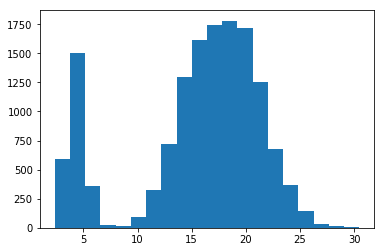

In [81]:
plt.hist(hrrp_df['predicted_readmission_rate'],bins=20);

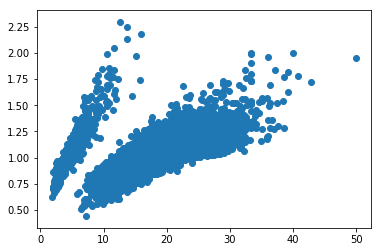

In [105]:
plt.scatter(hrrp_df['readmitrate_calc'],hrrp_df['readmitrate_ratio'])

In [112]:
hrrp_1 = hrrp_df.groupby(['provider_id']).count().sort_values(by='excess_readmission_ratio')
hrrp_1.loc[hrrp_1['excess_readmission_ratio'] < 6]

,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,readmitrate_calc,readmitrate_ratio
provider_id,,,,,,,,,,,,,
670124,6,6,6,0,0,0,0,0,6,6,6,0,0
450831,6,6,6,0,0,0,0,0,6,6,6,0,0
370199,6,6,6,0,0,0,0,0,6,6,6,0,0
370201,6,6,6,0,0,0,0,0,6,6,6,0,0
370206,6,6,6,0,0,0,0,0,6,6,6,0,0
050548,6,6,6,0,0,0,0,0,6,6,6,0,0
370214,6,6,6,0,0,0,0,0,6,6,6,0,0
370216,6,6,6,1,0,0,0,0,6,6,6,0,0
070038,6,6,6,0,0,0,0,0,6,6,6,0,0


(array([183., 169.,  67., 354., 583., 955., 968.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

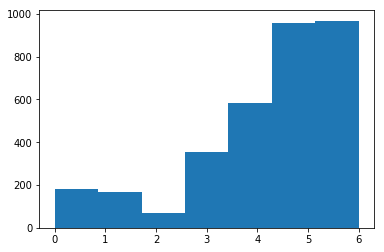

In [114]:
plt.hist(hrrp_1['excess_readmission_ratio'],bins=7)

In [121]:
hrrp_df.loc[hrrp_df['provider_id']=='230144']

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,readmitrate_calc,readmitrate_ratio
9036,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_AMI_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN
9037,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_CABG_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN
9038,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_COPD_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN
9039,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_HF_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN
9040,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_HIP_KNEE_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN
9041,FOREST HEALTH MEDICAL CENTER,230144,MI,READM_30_PN_HRRP,NaN,NaN,NaN,NaN,NaN,2014-07-01,2017-06-30,5 - Results are not available for this reporti...,NaN,NaN


In [143]:
check = hrrp_df.loc[(hrrp_df['number_of_discharges'].isna()) & (hrrp_df['excess_readmission_ratio'].isna() == False)]

In [145]:
check['measure_name'].value_counts()

READM_30_HIP_KNEE_HRRP    1184
READM_30_AMI_HRRP          421
READM_30_CABG_HRRP         413
READM_30_COPD_HRRP         318
READM_30_HF_HRRP           212
READM_30_PN_HRRP           200
Name: measure_name, dtype: int64

In [146]:
check2 = hrrp_df.loc[(hrrp_df['number_of_discharges'].isna())]
check2['measure_name'].value_counts()

READM_30_CABG_HRRP        2672
READM_30_HIP_KNEE_HRRP    1940
READM_30_AMI_HRRP         1567
READM_30_COPD_HRRP         719
READM_30_HF_HRRP           602
READM_30_PN_HRRP           519
Name: measure_name, dtype: int64

In [150]:
hrrp_2 = hrrp_df.dropna(subset = ['number_of_discharges','excess_readmission_ratio',
                                  'predicted_readmission_rate','expected_readmission_rate',
                                  'number_of_readmissions'])

In [151]:
hrrp_2.shape

(11532, 14)

In [203]:
def my_agg(x):
    names = {'weighted_avg_ERR': (x['excess_readmission_ratio'] * x['number_of_discharges']).sum()/x['number_of_discharges'].sum()}
    return pd.Series(names, index=['weighted_avg_ERR'])

hrrp_2_1 = hrrp_2.groupby(['provider_id'])[['number_of_discharges','number_of_readmissions']].sum()
hrrp_2_1['raw_avg_readmitrate'] = hrrp_2_1['number_of_readmissions']/hrrp_2_1['number_of_discharges']
hrrp_3 = hrrp_2.groupby(['provider_id','start_date','end_date'], as_index=False).apply(my_agg).reset_index()
hrrp_3 = pd.merge(hrrp_3,hrrp_2_1,on='provider_id')
hrrp_3.shape

(2895, 7)

In [204]:
hrrp_3.head(10)

,provider_id,start_date,end_date,weighted_avg_ERR,number_of_discharges,number_of_readmissions,raw_avg_readmitrate
0,010001,2014-07-01,2017-06-30,1.026958,3657.0,619.0,0.169264
1,010005,2014-07-01,2017-06-30,0.975498,2021.0,305.0,0.150915
2,010006,2014-07-01,2017-06-30,1.033804,3335.0,533.0,0.159820
3,010007,2014-07-01,2017-06-30,1.023081,427.0,79.0,0.185012
4,010011,2014-07-01,2017-06-30,0.975355,1604.0,272.0,0.169576
5,010012,2014-07-01,2017-06-30,1.004785,752.0,124.0,0.164894
6,010016,2014-07-01,2017-06-30,0.987508,1310.0,230.0,0.175573
7,010019,2014-07-01,2017-06-30,1.037402,1640.0,251.0,0.153049
8,010021,2014-07-01,2017-06-30,0.967344,369.0,61.0,0.165312
9,010023,2014-07-01,2017-06-30,1.037243,2282.0,377.0,0.165206


In [174]:
hrrp_2.loc[hrrp_2['provider_id']=='010005']

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,readmitrate_calc,readmitrate_ratio
8,MARSHALL MEDICAL CENTER SOUTH,010005,AL,READM_30_COPD_HRRP,641.0,0.9054,16.7351,18.4842,100.0,2014-07-01,2017-06-30,NaN,15.600624,0.932210
9,MARSHALL MEDICAL CENTER SOUTH,010005,AL,READM_30_HF_HRRP,337.0,1.0288,21.7164,21.1089,75.0,2014-07-01,2017-06-30,NaN,22.255193,1.024810
10,MARSHALL MEDICAL CENTER SOUTH,010005,AL,READM_30_HIP_KNEE_HRRP,284.0,1.0913,5.3414,4.8946,17.0,2014-07-01,2017-06-30,NaN,5.985915,1.120664
11,MARSHALL MEDICAL CENTER SOUTH,010005,AL,READM_30_PN_HRRP,759.0,0.9677,15.1414,15.6471,113.0,2014-07-01,2017-06-30,NaN,14.888011,0.983265


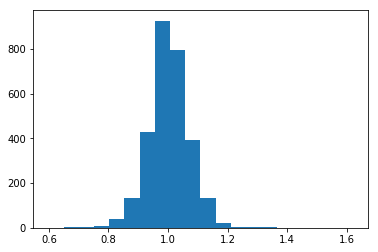

In [167]:
plt.hist(hrrp_3['weighted_avg_ERR'],bins=20);

### Wage Index data

In [182]:
wageindex = wageindex_df.loc[:,['CCN','Case_Mix_Indexes','FY_2017_Wage_Index','3_Year_Avg_Hourly_Wage_15_16_17']]
wageindex.head(5)

,CCN,Case_Mix_Indexes,FY_2017_Wage_Index,3_Year_Avg_Hourly_Wage_15_16_17
0,010001,1.6674,0.7685,29.0170
1,010005,1.3532,0.8062,27.8412
2,010006,1.6485,0.6846,27.2115
3,010007,1.0549,0.6846,23.5140
4,010008,0.9245,0.6973,25.5436


### Census Income data

In [238]:
#create county_state column for joining to hospital data
censusincome_df['state'] = [x[x.find(",")+2:] for x in censusincome_df['Geographic Area Name']]
censusincome_df['county_pre'] = [x[:x.find(",")].upper() for x in censusincome_df['Geographic Area Name']]
censusincome_df['county'] = [x[:x.find(" COUNTY")] for x in censusincome_df['county_pre']]
censusincome_df['county'].value_counts()

WASHINGTON            30
JEFFERSON             25
FRANKLIN              24
LINCOLN               23
JACKSON               23
MADISON               19
MONTGOMERY            18
CLAY                  18
MONROE                17
UNION                 17
MARION                17
WAYNE                 16
WARREN                14
GRANT                 14
GREENE                14
CARROLL               13
CLARK                 12
JOHNSON               12
ADAMS                 12
POLK                  12
LAKE                  12
MARSHALL              12
LEE                   12
DOUGLAS               12
LAWRENCE              11
CRAWFORD              11
MORGAN                11
FAYETTE               11
SCOTT                 11
CALHOUN               11
                      ..
TELLER                 1
LYNN                   1
OGLALA LAKOTA          1
TUNICA                 1
MARIN                  1
TILLAMOOK              1
JUNIATA                1
GALAX CIT              1
ROOKS                  1


In [266]:
censusincome_df['state'].value_counts()

# test = dict(map(censusincome_df,us_state_abbrev.items()))
censusincome_df.shape

censusincome_df['state_abbr'] = censusincome_df['state'].map(us_state_abbrev)
# sum(censusincome_df['state_abbr'].isna())
censusincome_df['county_st'] = censusincome_df['county']+"_"+censusincome_df['state_abbr']
censusincome_df['county_st'].value_counts()

#keep only the median household income column
censusincome = censusincome_df.loc[:,['county_st','Households!!Estimate!!Median income (dollars)']]
censusincome.rename(columns = {'Households!!Estimate!!Median income (dollars)':'median_household_income'}, inplace = True)
censusincome.head(5)

,county_st,median_household_income
0,WILCOX_AL,24442
1,WINSTON_AL,33896
2,ALEUTIANS EAST BOROUG_AK,65926
3,ALEUTIANS WEST CENSUS ARE_AK,86964
4,ANCHORAGE MUNICIPALIT_AK,80862


### Join data

In [274]:
#join readmit info to general hospital info

hosp = pd.merge(hrrp_3,geninfo,on='provider_id')
hosp = pd.merge(hosp,wageindex,left_on='provider_id',right_on='CCN').drop('CCN',axis=1)
hosp = pd.merge(hosp,censusincome,on='county_st')
hosp.info()
hosp.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2699 entries, 0 to 2698
Data columns (total 21 columns):
provider_id                        2699 non-null object
start_date                         2699 non-null datetime64[ns]
end_date                           2699 non-null datetime64[ns]
weighted_avg_ERR                   2699 non-null float64
number_of_discharges               2699 non-null float64
number_of_readmissions             2699 non-null float64
raw_avg_readmitrate                2699 non-null float64
hospital_name                      2699 non-null object
state                              2699 non-null object
zip_code                           2699 non-null object
county_name                        2699 non-null object
hospital_type                      2699 non-null object
hospital_ownership                 2699 non-null object
emergency_services                 2699 non-null bool
hospital_overall_rating            2699 non-null object
mortality_national_comparison      

,provider_id,start_date,end_date,weighted_avg_ERR,number_of_discharges,number_of_readmissions,raw_avg_readmitrate,hospital_name,state,zip_code,...,hospital_type,hospital_ownership,emergency_services,hospital_overall_rating,mortality_national_comparison,county_st,Case_Mix_Indexes,FY_2017_Wage_Index,3_Year_Avg_Hourly_Wage_15_16_17,median_household_income
0,010001,2014-07-01,2017-06-30,1.026958,3657.0,619.0,0.169264,SOUTHEAST ALABAMA MEDICAL CENTER,AL,36301,...,Acute Care Hospitals,Government - Hospital District or Authority,True,2,Below the national average,HOUSTON_AL,1.6674,0.7685,29.0170,41945
1,010055,2014-07-01,2017-06-30,0.974441,2468.0,328.0,0.132901,FLOWERS HOSPITAL,AL,36305,...,Acute Care Hospitals,Proprietary,True,3,Below the national average,HOUSTON_AL,1.6872,0.7685,28.3828,41945
2,010005,2014-07-01,2017-06-30,0.975498,2021.0,305.0,0.150915,MARSHALL MEDICAL CENTER SOUTH,AL,35957,...,Acute Care Hospitals,Government - Hospital District or Authority,True,1,Below the national average,MARSHALL_AL,1.3532,0.8062,27.8412,39831
3,010006,2014-07-01,2017-06-30,1.033804,3335.0,533.0,0.159820,NORTH ALABAMA MEDICAL CENTER,AL,35630,...,Acute Care Hospitals,Government - Hospital District or Authority,True,3,Below the national average,LAUDERDALE_AL,1.6485,0.6846,27.2115,43657
4,010007,2014-07-01,2017-06-30,1.023081,427.0,79.0,0.185012,MIZELL MEMORIAL HOSPITAL,AL,36467,...,Acute Care Hospitals,Voluntary non-profit - Private,True,1,Same as the national average,COVINGTON_AL,1.0549,0.6846,23.5140,37313
5,010036,2014-07-01,2017-06-30,1.038119,695.0,135.0,0.194245,ANDALUSIA HEALTH,AL,36420,...,Acute Care Hospitals,Proprietary,True,4,Same as the national average,COVINGTON_AL,1.2562,0.6846,27.8543,37313
6,010011,2014-07-01,2017-06-30,0.975355,1604.0,272.0,0.169576,ST VINCENT'S EAST,AL,35235,...,Acute Care Hospitals,Voluntary non-profit - Private,True,2,Same as the national average,JEFFERSON_AL,1.6728,0.8102,34.9671,47220
7,010033,2014-07-01,2017-06-30,1.032690,2850.0,512.0,0.179649,UNIVERSITY OF ALABAMA HOSPITAL,AL,35233,...,Acute Care Hospitals,Government - State,True,2,Above the national average,JEFFERSON_AL,2.3370,0.8102,35.3045,47220
8,010056,2014-07-01,2017-06-30,0.995912,3535.0,382.0,0.108062,ST VINCENT'S BIRMINGHAM,AL,35205,...,Acute Care Hospitals,Voluntary non-profit - Private,True,4,Same as the national average,JEFFERSON_AL,1.8501,0.8102,34.0086,47220
9,010103,2014-07-01,2017-06-30,0.998747,1742.0,278.0,0.159587,PRINCETON BAPTIST MEDICAL CENTER,AL,35211,...,Acute Care Hospitals,Voluntary non-profit - Church,True,2,Same as the national average,JEFFERSON_AL,2.0823,0.8102,30.7425,47220


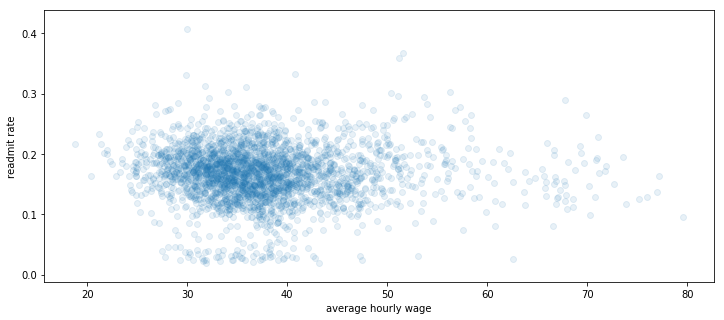

In [276]:
plt.figure(figsize=(12,5))
plt.scatter(hosp['3_Year_Avg_Hourly_Wage_15_16_17'],hosp['raw_avg_readmitrate'],alpha=0.1)
plt.xlabel('average hourly wage')
plt.ylabel('readmit rate');

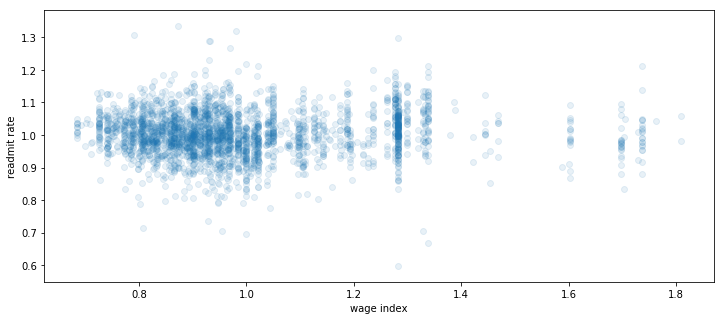

In [278]:
plt.figure(figsize=(12,5))
plt.scatter(hosp['FY_2017_Wage_Index'],hosp['weighted_avg_ERR'],alpha=0.1)
plt.xlabel('wage index')
plt.ylabel('readmit rate');

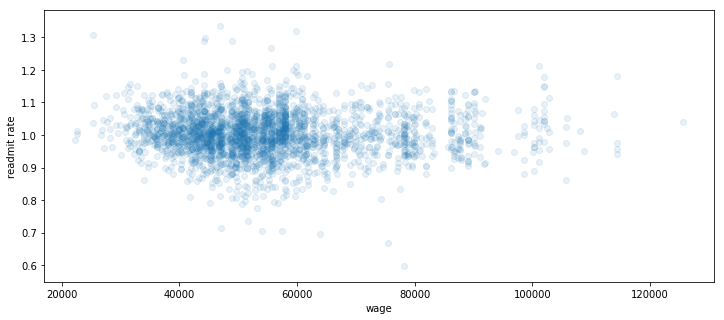

In [281]:
plt.figure(figsize=(12,5))
plt.scatter(hosp['median_household_income'],hosp['weighted_avg_ERR'],alpha=0.1)
plt.xlabel('wage')
plt.ylabel('readmit rate');